Working in: /Users/rjoshi_24/Desktop/CPI_Project
Looking for: CPI_CAD30YR.csv
✅ Found it. crunching the numbers...
Loaded 365 months of data (1995-06-01 to 2025-10-01)


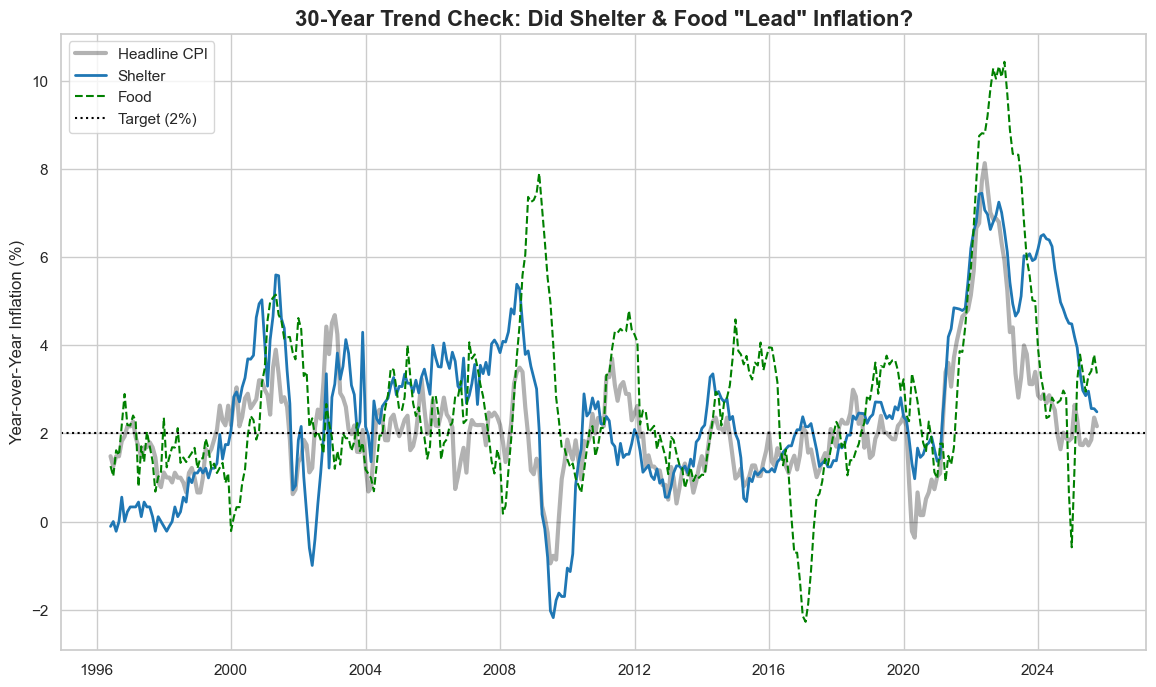

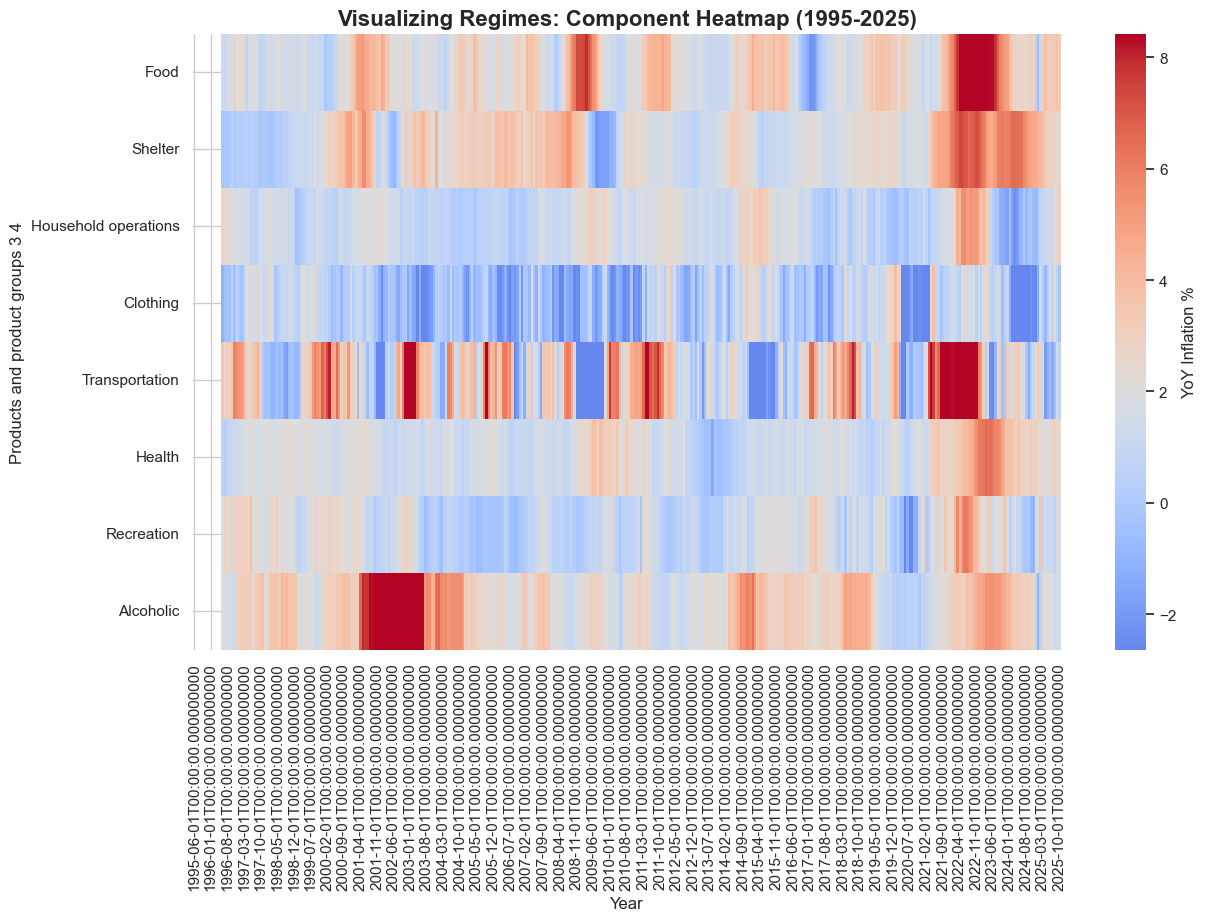

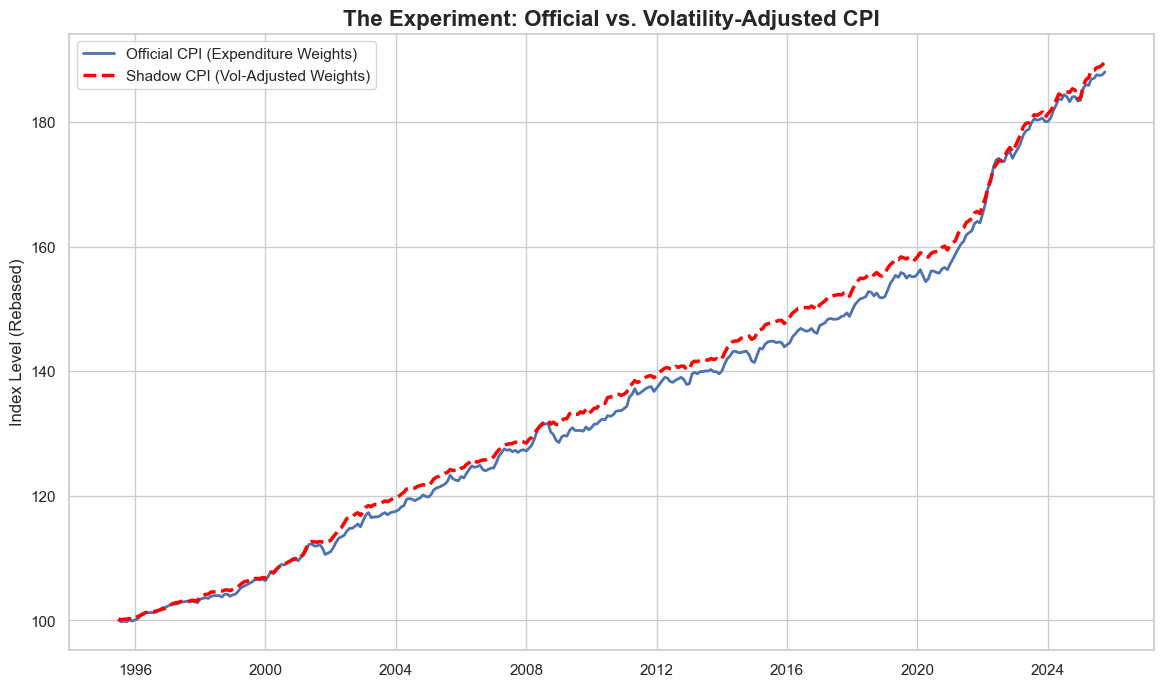


EXECUTIVE SUMMARY (October 2025)
1. SHELTER ANALYSIS
   - 30-Year Avg Shelter: 2.516%
   - 30-Year Avg Headline: 2.135%
   -> YES. Shelter is a structural leader (runs hotter than avg).
--------------------------------------------------
2. THE SHADOW INDEX SIGNAL
   - Official Inflation: 2.163%
   - Shadow Inflation:   2.336%
   - Divergence:         +0.173 bps

CONCLUSION: 'Real' Signal is HOTTER.
Core components are sticky. This is a Hawkish divergence.


In [9]:
# Project: 30-Year CPI Analysis & The "Shadow" Index
# Looking at 1995-2025 data to answer two things:
# 1. Did Shelter structurally lead inflation?
# 2. What happens if we re-weight the basket based on volatility (stability) instead of spending?

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Just setting up the chart style to look clean
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (14, 7)
plt.rcParams["axes.titlesize"] = 16

# Finding the file automatically so I don't have to hardcode paths
FILENAME = 'CPI_CAD30YR.csv'
print(f"Working in: {os.getcwd()}")
print(f"Looking for: {FILENAME}")

if not os.path.exists(FILENAME):
    print("\n❌ Can't find the file. Make sure CPI_CAD30YR.csv is in the same folder.")
else:
    print("✅ Found it. crunching the numbers...")

# ---------------------------------------------------------
# 1. CLEANING UP THE DATA
# ---------------------------------------------------------
try:
    # StatsCan data puts dates in columns, so I need to read starting at line 9
    raw_df = pd.read_csv(FILENAME, header=8)
    
    # Set the component names as the index
    raw_df.set_index(raw_df.columns[0], inplace=True)
    
    # Transpose it so Dates are rows and Components are columns (Standard time series format)
    df = raw_df.T

    # Had to force columns to strings here because some empty rows were being read as floats and breaking the filter later
    df.columns = df.columns.astype(str)
    
    # Cleaning up the date formatting
    df.index = df.index.str.strip()
    df.index = pd.to_datetime(df.index, format='%B %Y', errors='coerce')
    df = df[df.index.notnull()].sort_index()
    
    # Removing those annoying footnote numbers from column names (e.g. "Food 4")
    df.columns = df.columns.str.replace(r'\s\d', '', regex=True).str.strip()
    
    print(f"Loaded {len(df)} months of data ({df.index.min().date()} to {df.index.max().date()})")

except Exception as e:
    print(f"Something went wrong loading the data: {e}")

# ---------------------------------------------------------
# 2. FILTERING FOR THE MAJORS
# ---------------------------------------------------------
# Grabbing the 8 main components we care about
target_components = ['Food', 'Shelter', 'Household operations', 'Clothing', 
                     'Transportation', 'Health', 'Recreation', 'Alcoholic']

clean_map = {}
for target in target_components:
    # Logic: Find the column that contains the target word
    match = [col for col in df.columns if target in col]
    if match: clean_map[match[0]] = target

# Grab headline CPI too for comparison
headline_col = [col for col in df.columns if 'All-items' in col][0]

# Creating the clean dataframes
df_components = df[clean_map.keys()].rename(columns=clean_map).astype(float)
df_headline = df[[headline_col]].rename(columns={headline_col: 'Official_CPI'}).astype(float)

# ---------------------------------------------------------
# 3. ANALYSIS PART A: THE TRENDS
# ---------------------------------------------------------
# Checking the 30-year history. Did Shelter actually lead the way?
yoy_components = df_components.pct_change(12) * 100
yoy_headline = df_headline.pct_change(12) * 100

# Plotting Shelter & Food vs Headline
plt.figure(figsize=(14, 8))

# Keeping headline grey/black so the main drivers pop
plt.plot(yoy_headline, label='Headline CPI', color='black', linewidth=3, alpha=0.3)

# Highlighting Shelter and Food
plt.plot(yoy_components['Shelter'], label='Shelter', color='#1f77b4', linewidth=2)
plt.plot(yoy_components['Food'], label='Food', color='green', linewidth=1.5, linestyle='--')

plt.axhline(2, color='black', linestyle=':', label='Target (2%)')
plt.title('30-Year Trend Check: Did Shelter & Food "Lead" Inflation?', fontweight='bold')
plt.ylabel('Year-over-Year Inflation (%)')
plt.legend()
plt.show()

# Bonus: Heatmap to see the "Inflation Regimes" visually over time
plt.figure(figsize=(14, 8))
sns.heatmap(yoy_components.T, cmap='coolwarm', center=2, robust=True, cbar_kws={'label': 'YoY Inflation %'})
plt.title('Visualizing Regimes: Component Heatmap (1995-2025)', fontweight='bold')
plt.xlabel('Year')
plt.show()

# ---------------------------------------------------------
# 4. ANALYSIS PART B: THE "SHADOW" INDEX
# ---------------------------------------------------------
# Here is the experiment: Re-weighting based on stability (Inverse Volatility)
# Logic: If it's volatile (like Energy), it gets a low weight. If it's stable, it gets a high weight.

# 1. Get volatility (Standard Deviation of monthly returns)
monthly_returns = df_components.pct_change().dropna()
volatility = monthly_returns.std()

# 2. Calculate new weights (1 / Volatility)
inv_vol = 1 / volatility
stat_weights = inv_vol / inv_vol.sum()

# 3. Build the new index
stat_monthly_inflation = (monthly_returns * stat_weights).sum(axis=1)
shadow_index = (1 + stat_monthly_inflation).cumprod() * 100

# Re-basing the official CPI so they start at the same point for a fair comparison
start_date = shadow_index.index[0]
official_index_rebased = (df_headline.loc[start_date:] / df_headline.loc[start_date].iloc[0]) * 100

# Plotting the divergence
plt.figure(figsize=(14, 8))
plt.plot(official_index_rebased, label='Official CPI (Expenditure Weights)', linewidth=2)
plt.plot(shadow_index, label='Shadow CPI (Vol-Adjusted Weights)', color='red', linestyle='--', linewidth=2.5)

plt.title('The Experiment: Official vs. Volatility-Adjusted CPI', fontweight='bold')
plt.ylabel('Index Level (Rebased)')
plt.legend()
plt.show()

# ---------------------------------------------------------
# 5. THE VERDICT (SUMMARY)
# ---------------------------------------------------------
# Calculating the final spread to see if the signal is Hawkish or Dovish

shadow_yoy = shadow_index.pct_change(12) * 100
current_official = yoy_headline.iloc[-1].item()
current_shadow = shadow_yoy.iloc[-1]
spread = current_shadow - current_official

print("\n" + "="*50)
print(f"EXECUTIVE SUMMARY ({yoy_headline.index[-1].strftime('%B %Y')})")
print("="*50)

print(f"1. SHELTER ANALYSIS")
shelter_avg = yoy_components['Shelter'].mean()
headline_avg = yoy_headline['Official_CPI'].mean()
print(f"   - 30-Year Avg Shelter: {shelter_avg:.3f}%")
print(f"   - 30-Year Avg Headline: {headline_avg:.3f}%")
if shelter_avg > headline_avg:
    print("   -> YES. Shelter is a structural leader (runs hotter than avg).")
else:
    print("   -> NO. Shelter tracks inline.")

print("-" * 50)
print(f"2. THE SHADOW INDEX SIGNAL")
print(f"   - Official Inflation: {current_official:.3f}%")
print(f"   - Shadow Inflation:   {current_shadow:.3f}%")
print(f"   - Divergence:         {spread:+.3f} bps")

if spread < 0:
    print("\nCONCLUSION: 'Real' Signal is COOLER.")
    print("Headline is likely propped up by noise.")
else:
    print("\nCONCLUSION: 'Real' Signal is HOTTER.")
    print("Core components are sticky. This is a Hawkish divergence.")
print("="*50)